# Resistance plant gene prediction - EDA
---

## Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import MultiHeadAttention, Embedding, GlobalAveragePooling1D, Dropout, LayerNormalization

# Speed up the model's training
from tensorflow.keras import mixed_precision

# Helper functions 
import helper_functions as hf

2024-05-13 20:31:02.620841: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 20:31:02.639455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 20:31:02.639466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 20:31:02.639978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 20:31:02.643185: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
proteins = pd.read_csv('Data/train.csv')

In [3]:
proteins.head()

,ID,Sequence,Label
0,0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...,0
1,4,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...,0
2,5,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...,0
3,6,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...,0
4,7,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...,0


In [4]:
proteins.describe()

,ID,Label
count,14161.000000,14161.000000
mean,9469.114116,0.089965
std,5461.636271,0.286142
min,0.000000,0.000000
25%,4732.000000,0.000000
50%,9471.000000,0.000000
75%,14222.000000,0.000000
max,18881.000000,1.000000


In [5]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [6]:
proteins[proteins.duplicated()].shape

(0, 3)

##  Preparation

### Tokenization

In [7]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(proteins['Sequence'])
sequences = tokenizer.texts_to_sequences(proteins['Sequence'])

In [8]:
sequences = pd.DataFrame(sequences).fillna(0)
sequences

,0,1,2,3,4,5,6,7,8,9,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,17,9,2,8,17,9,15,16,6,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17,3,12,7,3,6,7,7,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17,1,6,1,18,14,6,14,10,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17,3,6,12,6,1,5,13,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,11,2,19,4,19,1,5,1,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14156,17,4,1,7,6,6,14,6,6,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14157,17,17,17,17,4,6,4,5,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14158,17,16,13,13,13,15,16,2,14,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14159,17,3,3,8,19,2,10,3,14,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

,Label
0,0
1,0
2,0
3,0
4,0


### Split and Standar Scaling

In [10]:
sequences_train, sequences_test, labels_train, labels_test = train_test_split(sequences, labels, test_size=0.2, random_state=33)

In [11]:
print('Training shapes: ', sequences_train.shape, labels_train.shape)
print('Test shapes: ', sequences_test.shape, labels_test.shape)

Training shapes:  (11328, 2028) (11328, 1)
Test shapes:  (2833, 2028) (2833, 1)


In [12]:
scaler = StandardScaler()
sequences_train_scaled = scaler.fit_transform(sequences_train)
sequences_test_scaled = scaler.fit_transform(sequences_test)

### Mixed precision

* Set up mix precision before modeling to speed up the training

In [13]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [14]:
tf.config.list_physical_devices()

2024-05-13 20:31:05.886947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:05.898134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:05.898169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-05-13 20:31:05.905225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [16]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling

In [36]:
sequence_len = sequences_train.shape[1]
voc_size = len(tokenizer.word_index)
embedding_dim = 256

### LSTM

In [18]:
inputs = Input(shape=(sequence_len, 1), name='Input')
# embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(inputs)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(lstms2)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

2024-05-13 20:31:11.297767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:11.297832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:11.297862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:11.445542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-13 20:31:11.445594: I external/local_xla/xla/stream_executor

In [19]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2028, 1)]         0         
                                                                 
 LSTM_layer_1 (LSTM)         (None, 2028, 20)          1760      
                                                                 
 LSTM_layer_2 (LSTM)         (None, 2028, 20)          3280      
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55        
                                                                 
 Output (Dense)              (None, 1)                 6     

In [20]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [21]:
history = model_1.fit(sequences_train, labels_train, epochs=2)

Epoch 1/2


2024-05-13 20:31:14.460180: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-13 20:31:15.700896: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fad84003750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 20:31:15.700935: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-13 20:31:15.705081: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715621475.767021    6914 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 [==============================] - 91s 249ms/step - loss: 0.4605 - accuracy: 0.9098
Epoch 2/2
354/354 [==============================] - 87s 246ms/step - loss: 0.3035 - accuracy: 0.9098


In [22]:
predictions = model_1.predict(sequences_test)

89/89 [==============================] - 13s 136ms/step


In [23]:
predictions = hf.model_accuracy(labels_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.301


In [24]:
hf.class_report(labels_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



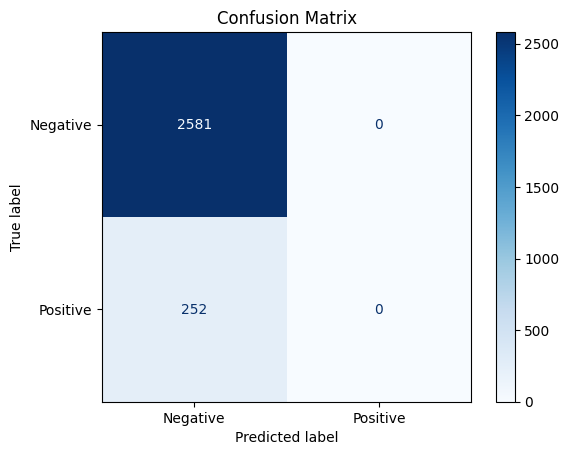

In [25]:
hf.conf_matrix(labels_test, predictions, 'lstm_baseline_cm')

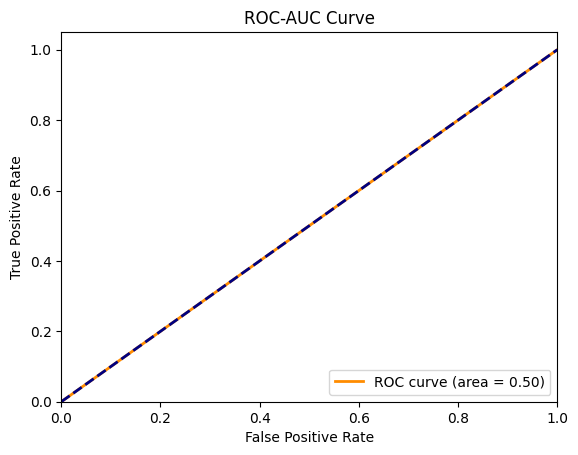

In [26]:
hf.roc_auc_curve(labels_test, predictions, 'lstm_baseline_roc_auc')

### Transformers

In [49]:
input_layer = Input(shape=(sequence_len), name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

attention = MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(x, x)
x = LayerNormalization(epsilon=1e-6)(x + attention)

dense = Dense(embedding_dim, activation='relu')(x)
dense = Dense(embedding_dim, activation='relu')(dense)

x = LayerNormalization(epsilon=1e-6)(x + dense)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)

outputs_layer = Dense(1, activation="sigmoid")(x)

In [40]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [41]:
transformer_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 2028)]               0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 2028, 256)            5888      ['Input[0][0]']               
                                                                                                  
 multi_head_attention_2 (Mu  (None, 2028, 256)            2103552   ['Embeddings[0][0]',          
 ltiHeadAttention)                                                   'Embeddings[0][0]']          
                                                                                                  
 tf.__operators__.add_4 (TF  (None, 2028, 256)            0         ['Embeddings[0][0]',    

In [42]:
history = transformer_1.fit(sequences_train, labels_train, epochs=1, batch_size=32)

354/354 [==============================] - 144s 403ms/step - loss: 0.3390 - accuracy: 0.9002


In [43]:
predictions = transformer_1.predict(sequences_test)

89/89 [==============================] - 14s 158ms/step


In [44]:
predictions = hf.model_accuracy(labels_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.3057


In [45]:
hf.class_report(labels_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



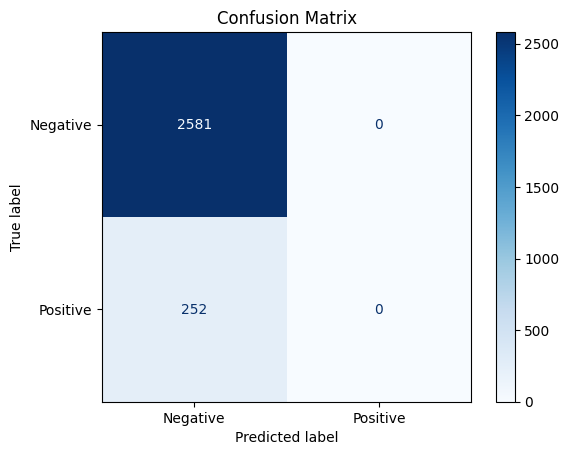

In [46]:
hf.conf_matrix(labels_test, predictions, 'transformer_1_cm')

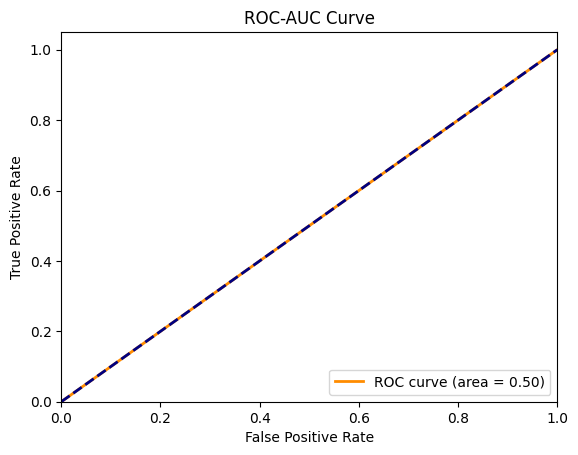

In [47]:
hf.roc_auc_curve(labels_test, predictions, 'transformer_1_roc_auc')

In [153]:
# def get_positional_encoding(max_seq_length, model_dim):
#     """Generate sinusoidal positional encodings."""
#     positional_encoding = np.array([
#         [pos / np.power(10000, 2 * (j // 2) / model_dim) for j in range(model_dim)]
#         if pos != 0 else np.zeros(model_dim)
#         for pos in range(max_seq_length)
#     ])
#     positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i
#     positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1
#     return tf.cast(positional_encoding, dtype=tf.float32)